In [12]:
import os
import cv2
import time
import string
import random
import numpy as np
import collections
import tensorflow as tf
from random import randint
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [2]:
print(tf.__version__)

2.9.3


In [5]:
folder = "/home/fizzer/ros_ws/training_for_reading/images/letter_crops/"

filenames = []

for file in os.listdir(folder):
  filenames.append(file)

filenames.sort()
filenames[0:4]

['A_001.png', 'A_002.png', 'A_003.png', 'A_004.png']

In [6]:
template_folder = "drive/MyDrive/images_for_sign_reading"
template_img_bgr = cv2.imread(template_folder + "/full_sign.jpg")

[ WARN:0@25.568] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('drive/MyDrive/images_for_sign_reading/full_sign.jpg'): can't open/read file: check file path/integrity


In [7]:
save_folder = "drive/MyDrive/letter_crops"
save_folder_2 = "drive/MyDrive/top_half_crops"
# os.makedirs(save_folder, exist_ok=True)

# Image generation and labelling

In [8]:
# setup object detection
sift = cv2.SIFT_create()
index_params = dict(algorithm=0, trees=5)
search_params = dict()
flann = cv2.FlannBasedMatcher(index_params, search_params)

In [9]:
def detection(i, filename):
    ''' SIFT PART '''

    # import images
    # template_img_bgr = cv2.imread(folder + "/full_sign.jpg")
    query_img_bgr = cv2.imread(folder + "/" + filename)

    template_img = cv2.cvtColor(template_img_bgr, cv2.COLOR_BGR2GRAY)
    query_img = cv2.cvtColor(query_img_bgr, cv2.COLOR_BGR2GRAY)

    # scale images
    scale_template = 0.4
    scale_query = 0.4
    downscaled_template = cv2.resize(template_img, None, fx=scale_template, fy=scale_template, interpolation=cv2.INTER_AREA)
    downscaled_query = cv2.resize(query_img, None, fx=scale_query, fy=scale_query, interpolation=cv2.INTER_AREA)

    # SIFT
    start_sift = time.time()
    keypoints1, descriptors1 = sift.detectAndCompute(downscaled_template, None)
    keypoints2, descriptors2 = sift.detectAndCompute(downscaled_query, None)
    end_sift = time.time()

    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
    MIN_MATCH_COUNT = 20

    # warp image
    if len(good_matches) <= MIN_MATCH_COUNT:
        return end_sift - start_sift

    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    H, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

    if H is None or H.shape != (3, 3):
        return end_sift - start_sift

    S_query = np.array([[scale_query, 0, 0], [0, scale_query, 0], [0, 0, 1]], dtype=np.float32)
    S_template_inv = np.array([[1/scale_template, 0, 0], [0, 1/scale_template, 0], [0, 0, 1]], dtype=np.float32)
    H_original_scale = S_template_inv @ H @ S_query

    warped_img = cv2.warpPerspective(query_img_bgr, H_original_scale, (template_img.shape[1], template_img.shape[0]))

    #TODO: check if white frame surrounds fully on all sides
    #TODO: determine if warp is 'good' or 'bad'

    ''' CROPPING PART '''

    # threshold by searching for blue
    hsv = cv2.cvtColor(warped_img, cv2.COLOR_BGR2HSV)
    lower_blue = np.array([100, 150, 50])
    upper_blue = np.array([130, 255, 255])
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # clean up cracks and gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    mask_cleaned = cv2.morphologyEx(blue_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # flood fill to get rid of the white surrounding frame starting at (10,10)
    flood_filled = mask_cleaned.copy()
    cv2.floodFill(flood_filled, None, (10, 10), 0)

    #TODO: crop image in half, pass top half into CNN, bottom half keep processing

    # find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(flood_filled, connectivity=4)

    # filter connected component blobs
    min_area = 300
    letter_boxes = []
    for label in range(1, num_labels):  # skip label 0 (background)
        x, y, w, h, area = stats[label]
        if area >= min_area:
            letter_boxes.append((x, y, w, h))

    # sort in order top and bottom, and left to right
    img_height = flood_filled.shape[0]
    top_half = []
    bottom_half = []

    for box in letter_boxes:
        x, y, w, h = box
        center_y = y + h // 2
        if center_y < img_height / 2:
            top_half.append(box)
        else:
            bottom_half.append(box)

    top_half = sorted(top_half, key=lambda b: b[0])
    bottom_half = sorted(bottom_half, key=lambda b: b[0])
    letter_boxes = top_half + bottom_half

    # plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 5, 1)
    plt.imshow(downscaled_query, cmap='gray')
    plt.title("Downscaled Query")

    plt.subplot(1, 5, 2)
    plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
    plt.title("Warped Image")

    debug_img = cv2.cvtColor(flood_filled, cv2.COLOR_GRAY2BGR)
    for (x, y, w, h) in letter_boxes:
        cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0, 255, 0), 2)

    plt.subplot(1,5,3)
    plt.imshow(mask_cleaned,  cmap='gray')
    plt.title("Thresholded and Cleaned")

    plt.subplot(1,5,4)
    plt.imshow(flood_filled,  cmap='gray')
    plt.title("Flood Filled")

    plt.subplot(1, 5, 5)
    plt.imshow(debug_img)
    plt.title("Detected Letters")
    plt.axis('off')
    plt.show()

    # crop/pad all boxes to the same size
    target_width = 200
    target_height = 240

    letter_crops = []

    for (x, y, w, h) in letter_boxes:
        crop = flood_filled[y:y+h, x:x+w]

        if h > target_height or w > target_width:
            crop = cv2.resize(crop, (min(w, target_width), min(h, target_height)), interpolation=cv2.INTER_AREA)
            h, w = crop.shape

        pad_top = (target_height - h) // 2
        pad_bottom = target_height - h - pad_top
        pad_left = (target_width - w) // 2
        pad_right = target_width - w - pad_left

        padded_crop = cv2.copyMakeBorder(
            crop,
            top=pad_top, bottom=pad_bottom,
            left=pad_left, right=pad_right,
            borderType=cv2.BORDER_CONSTANT,
            value=0
        )

        letter_crops.append(padded_crop)


    save_path = os.path.join(save_folder_2, f"{i}.png")
    cv2.imwrite(save_path, flood_filled[0:img_height])

    # # Plot each cropped letter
    # if len(letter_crops) > 0:
    #     for idx, crop in enumerate(letter_crops):
    #         save_path = os.path.join(save_folder, f"{i}{idx}.png")
    #         cv2.imwrite(save_path, crop)

    #     cols = min(10, len(letter_crops))
    #     rows = int(np.ceil(len(letter_crops) / cols))
    #     fig, axs = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))

    #     if rows == 1:
    #         axs = np.expand_dims(axs, axis=0)

    #     for idx, crop in enumerate(letter_crops):
    #         r, c = divmod(idx, cols)
    #         axs[r][c].imshow(crop, cmap='gray')
    #         axs[r][c].axis('off')

    #     for i in range(len(letter_crops), rows * cols):
    #         r, c = divmod(i, cols)
    #         axs[r][c].axis('off')

    #     plt.suptitle("Extracted Letters", fontsize=16)
    #     plt.tight_layout()
    #     plt.show()
    # else:
    #     print(f"Frame {i}: No letters detected.")

    return end_sift - start_sift


In [10]:
print(len(filenames))

342


In [11]:
n = 170
random_filenames = random.sample(filenames, n)
total_time = 0.0

for i, filename in enumerate(random_filenames):
    total_time = total_time + detection(i, filename)

print("AVERAGE SIFT TIME: ", total_time/n)

error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


# Import labelled images

In [13]:
image_folder = "/home/fizzer/ros_ws/training_for_reading/images/letter_crops/"

image_filenames = []

for file in os.listdir(image_folder):
  image_filenames.append(file)

image_filenames.sort()
image_filenames[0:4]

['A_001.png', 'A_002.png', 'A_003.png', 'A_004.png']

In [14]:
print(f"Number of unique image files: {len(set(image_filenames))}")

Number of unique image files: 342


In [15]:
full_dataset_images = []
full_dataset_labels = []

datagen = ImageDataGenerator(
    rotation_range=4,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

extra_labels = {
    3: 4,  5: 2,  6: 2,  7: 4,  9: 2, #d, f, g, h, j
    10: 2, 13: 2, 15: 2, 16: 2, 17: 2, #k, n, p, q, r
    18: 2, 20: 10, 22: 2, 23: 2, 24: 2, 25: 2 #s, u, v, w, x, y, z
}

DEFAULT_NUM = 1  # if not in extra labels

for image_filename in image_filenames:
    image_path = os.path.join(image_folder, image_filename)
    image_array = np.array(Image.open(image_path))
    image_array = np.expand_dims(image_array, axis=-1)
    image_array = np.expand_dims(image_array, axis=0)

    label = int(ord(image_filename[0]) - 65)  # A-Z to 0-25

    num_to_generate = 4*extra_labels.get(label, DEFAULT_NUM)

    datagen_iterator = datagen.flow(image_array, batch_size=1)

    for _ in range(num_to_generate):
        value = next(datagen_iterator)
        img = value[0].astype('uint8')

        full_dataset_images.append(img)
        full_dataset_labels.append(label)

print(f"Total images: {len(full_dataset_images)}")
print(f"Total labels: {len(full_dataset_labels)}")


Total images: 2080
Total labels: 2080


Unique Labels in Full Set: 26


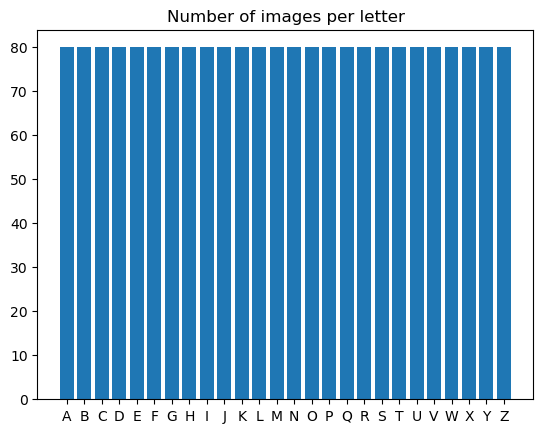

In [16]:
print("Unique Labels in Full Set:", len(np.unique(full_dataset_labels)))

counter = collections.Counter(full_dataset_labels)
plt.bar(range(26), [counter[i] for i in range(26)])
plt.xticks(range(26), [chr(i+65) for i in range(26)])
plt.title("Number of images per letter")
plt.show()

In [21]:
num_samples = len(full_dataset_images)
indices = np.arange(num_samples)
np.random.shuffle(indices)

shuffled_images = np.array(full_dataset_images)[indices]
shuffled_labels = np.array(full_dataset_labels)[indices]

# Define split percentages
train_split = 0.7
val_split = 0.15
test_split = 0.15

# Calculate split indices
train_end = int(train_split * num_samples)
val_end = train_end + int(val_split * num_samples)

# Perform the splits
train_images, train_labels = shuffled_images[:train_end], shuffled_labels[:train_end]
val_images, val_labels = shuffled_images[train_end:val_end], shuffled_labels[train_end:val_end]
test_images, test_labels = shuffled_images[val_end:], shuffled_labels[val_end:]

# Free up memory
del shuffled_images
del shuffled_labels

# Print stats
print(f"Training set: {len(train_images)} images")
print(f"Validation set: {len(val_images)} images")
print(f"Test set: {len(test_images)} images")

Training set: 1456 images
Validation set: 312 images
Test set: 312 images


25


TypeError: Invalid shape (240, 200, 1) for image data

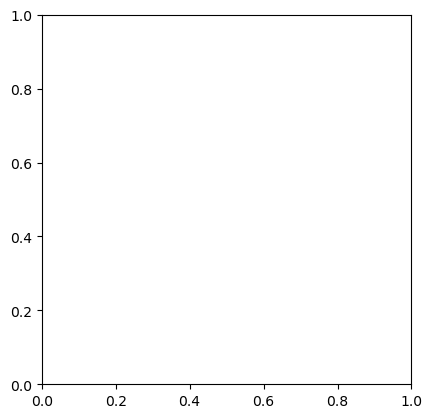

In [22]:
print(train_labels[100])
plt.imshow(train_images[100])

In [23]:
train_images = train_images.astype(np.float32, copy=False) # convert
train_images /= 255.0  # normalize

val_images = val_images.astype(np.float32, copy=False)
val_images /= 255.0

test_images = test_images.astype(np.float32, copy=False)
test_images /= 255.0

print("Image shape:", train_images[0].shape)
print(type(train_images[0]))
print(train_images[0].dtype)

Image shape: (240, 200, 1)
<class 'numpy.ndarray'>
float32


In [24]:
print("Unique Labels in Training Set:", len(np.unique(train_labels)))
print("Unique Labels in Validation Set:",len(np.unique(val_labels)))
print("Unique Labels in Test Set:",len(np.unique(test_labels)))

Unique Labels in Training Set: 26
Unique Labels in Validation Set: 26
Unique Labels in Test Set: 26


In [25]:
from tensorflow.keras.utils import to_categorical

num_classes = 26

# convert integer labels to one-hot encoding
train_labels = to_categorical(train_labels, num_classes=num_classes)
val_labels = to_categorical(val_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)

print("Train Images and Labels Shape:", train_images.shape, train_labels.shape)
print("Example One-Hot Encoded Label:\n", train_labels[0])

Train Images and Labels Shape: (1456, 240, 200, 1) (1456, 26)
Example One-Hot Encoded Label:
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [26]:
new_size = (40, 48)  # cv2 uses (width, height)

def resize_dataset(images, new_size):
    resized_images = []
    for img in images:
        # If image is (240, 200) without channel, add channel dimension
        if img.ndim == 2:
            img = np.expand_dims(img, axis=-1)
        # Resize each image and preserve single channel
        resized = cv2.resize(img, new_size, interpolation=cv2.INTER_AREA)
        resized = np.expand_dims(resized, axis=-1)  # Ensure shape is (H, W, 1)
        resized_images.append(resized)
    return np.array(resized_images)

train_images_resized = resize_dataset(train_images, new_size)
val_images_resized   = resize_dataset(val_images, new_size)
test_images_resized  = resize_dataset(test_images, new_size)

print("Resized Train:", train_images_resized.shape)
print("Resized Val:  ", val_images_resized.shape)
print("Resized Test: ", test_images_resized.shape)

Resized Train: (1456, 48, 40, 1)
Resized Val:   (312, 48, 40, 1)
Resized Test:  (312, 48, 40, 1)


# CNN

In [27]:
# # define CNN model
# conv_model = models.Sequential()

# conv_model.add(layers.Input(shape=(240, 200, 1)))
# conv_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))

# conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))

# conv_modeel.add(layers.Flatten())
# conv_model.add(layers.Dropout(0.5))  # dropout layer to prevent overfitting
# conv_model.add(layers.Dense(256, activation='relu'))
# conv_model.add(layers.Dense(26, activation='softmax'))

model = models.Sequential()

# Conv Block 1
model.add(layers.Input(shape=(48, 40, 1))) #(shape=(240, 200, 1))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Conv Block 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Conv Block 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Fully Connected Layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))  # Reduces overfitting
model.add(layers.Dense(26, activation='softmax'))  # 26 classes (A-Z)

# compile model
LEARNING_RATE = 1e-4
model.compile(
    loss='categorical_crossentropy',
    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)

# save initial weights
initial_weights = model.get_weights()

# model.save("model_run_4.keras")  # This creates a folder with saved_model.pb + variables/

In [24]:
small_X = train_images_resized[:5]
small_Y = train_labels[:5]

model.set_weights(initial_weights)  # Reset

history = model.fit(
    small_X, small_Y,
    epochs=100,
    verbose=0
)

preds = model.predict(small_X)
print(np.argmax(preds, axis=1))
print(np.argmax(small_Y, axis=1))

2025-03-28 19:06:25.293319: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2025-03-28 19:06:37.391665: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 0s 121ms/step
[ 8 20  7 20 20]
[ 8  2 22 14  1]


In [27]:
#model = keras.models.load_model("V3_model_stripped.h5")

# compile model
LEARNING_RATE = 1e-4
model.compile(
    loss='categorical_crossentropy',
    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)

In [ ]:
# set weights (either reset or load saved weights)
# model.set_weights(initial_weights)
#model.load_weights(f"V2_weights_run_3.weights.h5")

EPOCHS = 500
BATCH_SIZE = 16

callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=50,  # Increased from 10
            min_delta=0.00001,  # Minimum change to qualify as improvement
            mode='min',
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,  # Wait longer before reducing LR
            verbose=1
        )
    ]

history_conv = model.fit(
    train_images_resized, train_labels,
    validation_data=(val_images_resized, val_labels),
    epochs=EPOCHS,
    callbacks=callbacks,
    batch_size=BATCH_SIZE
)

model.save_weights(f"V2_weights_run_4.weights.h5")
model.save("/home/fizzer/ros_ws/training_for_reading/V4_model_stripped.h5", include_optimizer=False)

Epoch 1/500


2025-03-28 22:34:30.294344: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2025-03-28 22:34:31.584831: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


91/91 [==============================] - 5s 6ms/step - loss: 3.0326 - accuracy: 0.2534 - val_loss: 3.4986 - val_accuracy: 0.0962 - lr: 1.0000e-04
Epoch 2/500
91/91 [==============================] - 0s 3ms/step - loss: 1.1585 - accuracy: 0.6518 - val_loss: 3.5793 - val_accuracy: 0.1218 - lr: 1.0000e-04
Epoch 3/500
91/91 [==============================] - 0s 5ms/step - loss: 0.6105 - accuracy: 0.8207 - val_loss: 3.0565 - val_accuracy: 0.1731 - lr: 1.0000e-04
Epoch 4/500
91/91 [==============================] - 0s 5ms/step - loss: 0.3482 - accuracy: 0.9141 - val_loss: 2.0923 - val_accuracy: 0.3141 - lr: 1.0000e-04
Epoch 5/500
91/91 [==============================] - 0s 4ms/step - loss: 0.2505 - accuracy: 0.9348 - val_loss: 1.0322 - val_accuracy: 0.7404 - lr: 1.0000e-04
Epoch 6/500
91/91 [==============================] - 0s 4ms/step - loss: 0.1867 - accuracy: 0.9581 - val_loss: 0.4148 - val_accuracy: 0.9103 - lr: 1.0000e-04
Epoch 7/500
91/91 [==============================] - 0s 5ms/step

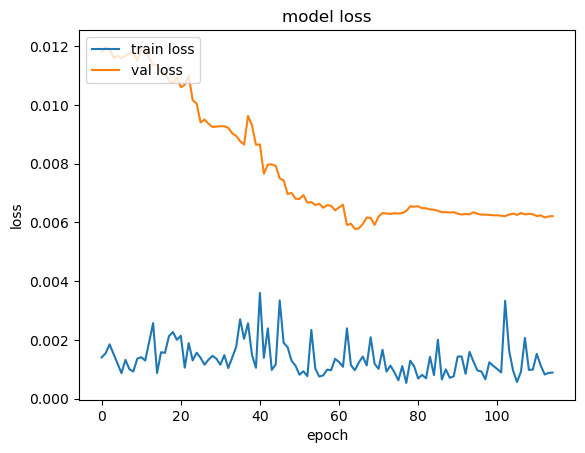

In [31]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 38, 32)        320       
                                                                 
 batch_normalization_3 (Batc  (None, 46, 38, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 19, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 17, 64)        18496     
                                                                 
 batch_normalization_4 (Batc  (None, 21, 17, 64)       256       
 hNormalization)                                                 
                                                      

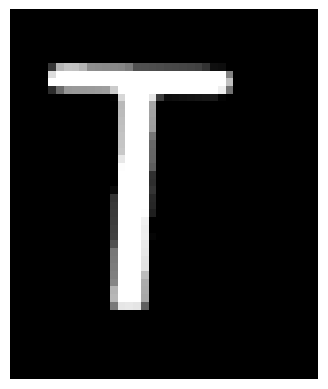

True label (one-hot): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0.]
True label (letter): T
1/1 [==============================] - 0s 74ms/step
Predicted label (letter): T


In [33]:
plt.imshow(test_images_resized[10].squeeze(), cmap='gray')  # squeeze to remove extra dimension
plt.axis('off')
plt.show()

print("True label (one-hot):", test_labels[10])

true_class = np.argmax(test_labels[10])
print("True label (letter):", chr(true_class + 65))

pred = model.predict(np.expand_dims(test_images_resized[10], axis=0))
predicted_class = np.argmax(pred)
print("Predicted label (letter):", chr(predicted_class + 65))


In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

test_loss, test_acc = model.evaluate(test_images_resized, test_labels, verbose=0)
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

predictions = model.predict(test_images_resized)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

print("Classification Report:\n")
print(classification_report(true_classes, predicted_classes, digits=3))

conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d',
            cmap='Blues',
            xticklabels=[chr(i) for i in range(65, 91)],
            yticklabels=[chr(i) for i in range(65, 91)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

ModuleNotFoundError: No module named 'seaborn'

# Model saving, quantization, attempted pruning

In [ ]:
model.save("V3_model_stripped.h5", include_optimizer=False)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open("V2_model_quantized.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp5wocdxet'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 40, 1), dtype=tf.float32, name='keras_tensor_276')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  133348874365712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133348874366288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133348874365520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133348874367056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133348874366480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133348874365904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133348874367440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133348874368976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133348874367824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133348874369360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13334887436

In [ ]:
import tempfile  # Library for creating temporary files and directories
from tensorflow_model_optimization.python.core.sparsity.keras.pruning_wrapper import PruneLowMagnitude  # Pruning wrapper for Keras models
import tensorflow_model_optimization as tfmot  # TensorFlow Model Optimization toolkit

from tensorflow import keras

model = keras.models.load_model("model_run_4.keras")

model.summary()


def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

# Convert the pruned Keras model to a quantized TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

# Save the quantized and pruned TensorFlow Lite model to a temporary file
_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')
with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

# Print the path to the saved quantized and pruned TFLite model
print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)

# Calculate and print the sizes of the gzipped models
# print("Size of gzipped baseline Keras model: %.2f bytes" % (keras_size))
quantized_and_pruned_tflite_size = get_gzipped_model_size(quantized_and_pruned_tflite_file)
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (quantized_and_pruned_tflite_size))


In [ ]:
model.save("model_stripped.h5", include_optimizer=False)

import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open("model_quantized.tflite", "wb") as f:
    f.write(tflite_model)